In [1]:
import numpy as np
import torch
from kan import KAN as PyKAN

## Generate the dataset

In [18]:
G = 1  #6.67430e-11


def generate_gravity_dataset(num_samples=1000, noise_std=1e-12):
    m1, m2 = np.random.uniform(0.5, 1, num_samples), np.random.uniform(0.5, 1, num_samples)
    # dx, dy, dz = (np.random.uniform(-1, 1, num_samples),
    #               np.random.uniform(-1, 1, num_samples),
    #               np.random.uniform(-1, 1, num_samples))
    d = np.random.uniform(0.5, 1, num_samples)
    # r = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    r = d
    F = (m1 * m2) / (r ** 2)

    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, num_samples)
    return np.column_stack((m1, m2, d)), F  #+ noise

In [20]:
train_set = generate_gravity_dataset(num_samples=1000, noise_std=1e-12)
test_set = generate_gravity_dataset(num_samples=500, noise_std=1e-12)
dataset = {
    'train_input': torch.tensor(train_set[0], dtype=torch.float32),
    'train_label': torch.tensor(train_set[1], dtype=torch.float32),
    'test_input': torch.tensor(test_set[0], dtype=torch.float32),
    'test_label': torch.tensor(test_set[1], dtype=torch.float32),
}
train_set[0], train_set[1]

(array([[0.64492805, 0.55851729, 0.76177925],
        [0.64013416, 0.70438723, 0.73046234],
        [0.61015284, 0.83971118, 0.6779207 ],
        ...,
        [0.58032102, 0.58405064, 0.82593646],
        [0.82604326, 0.72560974, 0.9926209 ],
        [0.65378563, 0.96445274, 0.92506045]]),
 array([0.62071124, 0.84505859, 1.11483548, 0.69466471, 0.73257812,
        2.67130338, 0.51678176, 1.82953994, 0.41623437, 1.45018295,
        1.42265391, 0.54329543, 1.14262877, 0.76327597, 1.11716289,
        0.63212421, 1.33805221, 0.9474693 , 1.398387  , 1.91133474,
        0.85689605, 1.32777828, 1.21464243, 1.01720173, 0.97594778,
        0.94328738, 0.55039733, 0.53025538, 0.62155883, 0.87948438,
        0.93918805, 1.08121753, 0.55058732, 0.42851329, 0.83712506,
        0.56411871, 0.79586883, 1.70753459, 1.34739917, 1.39770214,
        0.48114664, 0.92703099, 0.48379525, 0.7451123 , 0.72857706,
        0.71476282, 0.7103609 , 0.71767337, 1.23612901, 0.46388198,
        0.84083251, 0.6296250

## Train the KAN

In [32]:
model = PyKAN(width=[3, 3, 3, 3, 1, 1], grid=3, k=3, grid_range=[0.5, 1])
model.fit(dataset, opt="LBFGS", steps=40, lamb=0.01, lamb_entropy=100)
pass

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.00e-01 | test_loss: 9.91e+00 | reg: 1.83e+02 | : 100%|█| 40/40 [00:29<00:00,  1.37it

saving model version 0.1


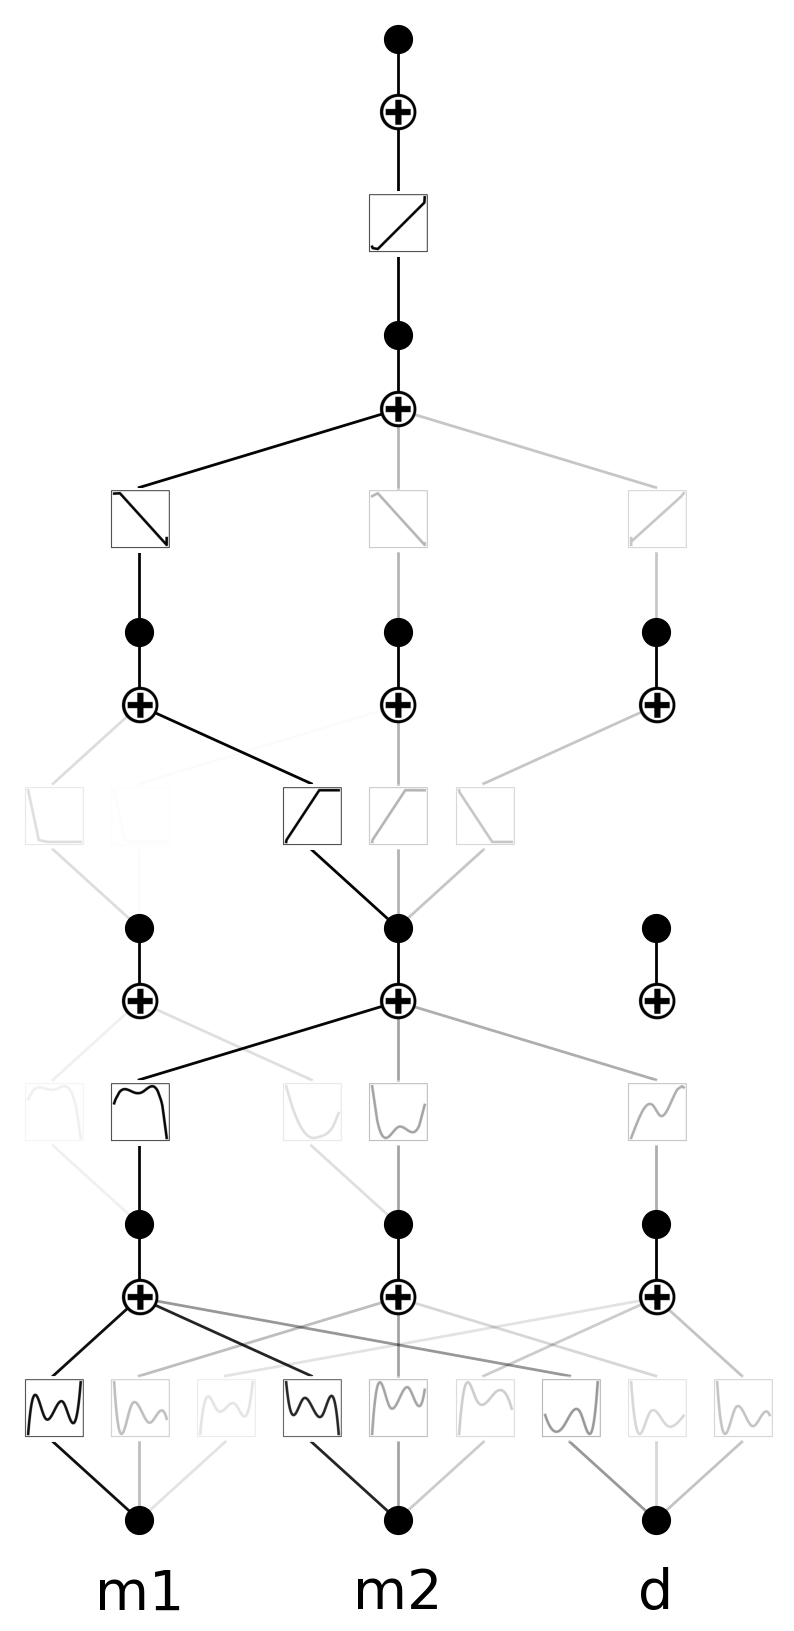

In [33]:
model.plot(in_vars=['m1', 'm2', 'd'], scale=1)